# Final Project B: Retail
### by Harry Zarcadoolas & Gabe De Brito
#### IMPORTANT NOTE: The project description assumes the data is browsing data, but it is transactional data. So, in some sections different analysis was performed. For example, you can't see how likely a customer is to buy a product because every customer has a transaction because it'd be 100%. Instead, we analyze the transactions themselves.

In [1]:
!where python

c:\Users\harry\anaconda3\envs\env-final-project\python.exe
C:\Program Files\Python312\python.exe
C:\Users\harry\AppData\Local\Microsoft\WindowsApps\python.exe
C:\msys64\ucrt64\bin\python.exe
C:\Users\harry\anaconda3\python.exe


#### Library Imports

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

## 1. Data Exploration

In [3]:
# Load the data
original_data = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx')

In [4]:
# Verify column names
print("Initial column names:\n", original_data.columns)

Initial column names:
 Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


### Data Cleaning and Preprocessing

In [41]:
# Create a copy of the original data
data_copy = original_data.copy()

# Adjust column names for consistency with project pdf
data_copy.rename(columns={
    'Invoice': 'InvoiceNo',
    'Price': 'UnitPrice',
    'Customer ID': 'CustomerID'
}, inplace=True)

# Address missing values
print("Missing values before cleaning:\n", data_copy.isnull().sum(), "\n")
if data_copy.isnull().sum().sum() == 0:
    print('\nNo missing values')
else:
    print('Missing values found')
    data_copy = data_copy.dropna()
    print('Missing values removed')
    print("Missing values after cleaning for confirmation:\n", data_copy.isnull().sum())

# Remove negative or zero quantities and prices
print("\nRemoving negative quantities and prices...")
data_copy = data_copy[(data_copy['Quantity'] > 0) & (data_copy['UnitPrice'] > 0)]

# Create a TotalPrice column
print("Creating TotalPrice column by multiplying Quantity and UnitPrice...")
data_copy['TotalPrice'] = data_copy['Quantity'] * data_copy['UnitPrice']

# Extract time-based features from InvoiceDate column
print("Extracting time-based features from InvoiceDate column...")
data_copy['InvoiceDate'] = pd.to_datetime(data_copy['InvoiceDate'])

print("Tasks Completed\n\n")

Missing values before cleaning:
 InvoiceNo           0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     107927
Country             0
dtype: int64 

Missing values found
Missing values removed
Missing values after cleaning for confirmation:
 InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Removing negative quantities and prices...
Creating TotalPrice column by multiplying Quantity and UnitPrice...
Extracting time-based features from InvoiceDate column...
Tasks Completed




### See where customers are shopping from to target consumer locations

C:\Users\harry\AppData\Local\Temp\ipykernel_17628\2113233930.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')


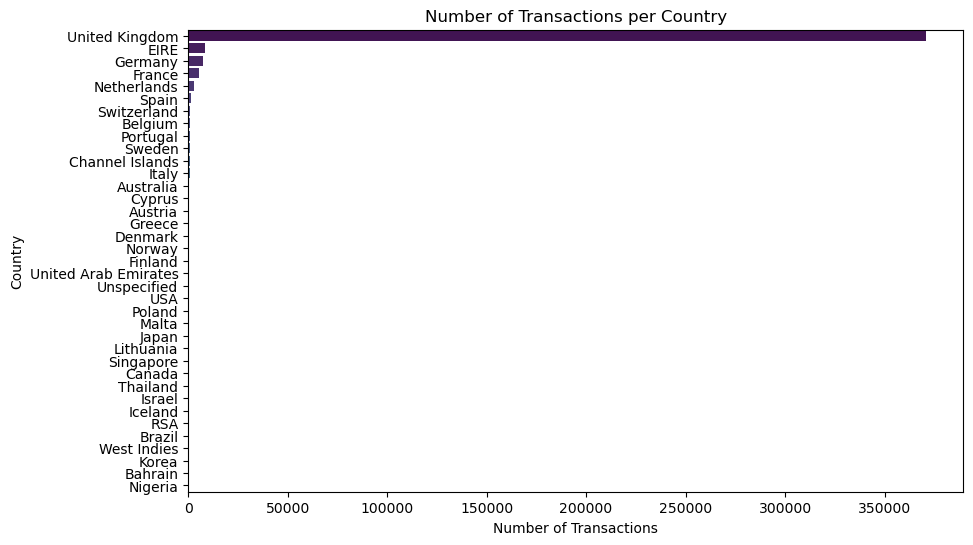

In [13]:
# Group by country and count the number of transactions
country_counts = data_copy['Country'].value_counts()

# Plot the number of transactions per country
plt.figure(figsize=(10, 6))
sns.barplot(y=country_counts.index, x=country_counts.values, palette='viridis')
plt.title('Number of Transactions per Country')
plt.xlabel('Number of Transactions')
plt.ylabel('Country')
plt.show()

del country_counts

### View monthly sales trends to see months of most revenue

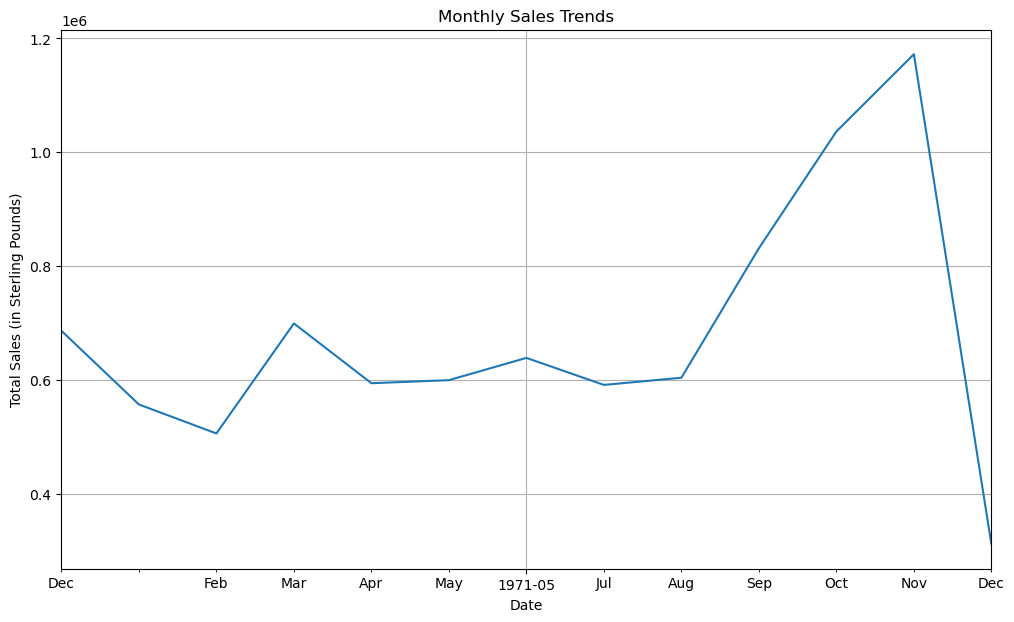

In [30]:
# Set the InvoiceDate as the index of the DataFrame
data_copy.set_index('InvoiceDate', inplace=True)

# Resample the data to monthly frequency and calculate the total sales for each month
monthly_sales = data_copy['TotalPrice'].resample('ME').sum()

# Plot the sales trends over time
plt.figure(figsize=(12, 7))
monthly_sales.plot()
plt.title('Monthly Sales Trends')
plt.xlabel('Date')
plt.ylabel('Total Sales (in Sterling Pounds)')
plt.grid(True)

# Customize the date format on the x-axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())

plt.show()

# Reset the index to avoid issues with subsequent operations
data_copy.reset_index(inplace=True)

del monthly_sales

### Items that generate the most revenue and total revenue

In [27]:
# Group by item description and sum the total price for each item
item_revenue = data_copy.groupby('Description')['TotalPrice'].sum()

# Sort the items by revenue in descending order
top_items = item_revenue.sort_values(ascending=False)
# Calculate the percentage of total revenue for each item
total_revenue = top_items.sum()
top_items_percentage = (top_items / total_revenue) * 100

print("Total revenue: (sterling pounds) £", total_revenue, '\n')

# Combine the revenue and percentage into a single DataFrame
top_items_df = pd.DataFrame({'Revenue': top_items, 'Percentage': top_items_percentage})

print("Top 10 items generating the most revenue (in £):\n", top_items_df.head(10))

del item_revenue, top_items, top_items_percentage, top_items_df

Total revenue: (sterling pounds) £ 8832003.274 

Top 10 items generating the most revenue (in £):
                                        Revenue  Percentage
Description                                               
WHITE HANGING HEART T-LIGHT HOLDER   151624.31    1.716760
REGENCY CAKESTAND 3 TIER             143893.35    1.629227
Manual                                98560.64    1.115949
ASSORTED COLOUR BIRD ORNAMENT         70493.83    0.798164
JUMBO BAG RED RETROSPOT               51759.30    0.586043
POSTAGE                               48741.08    0.551869
ROTATING SILVER ANGELS T-LIGHT HLDR   40186.65    0.455012
PAPER CHAIN KIT 50'S CHRISTMAS        36933.50    0.418178
PARTY BUNTING                         35035.90    0.396693
EDWARDIAN PARASOL NATURAL             34044.75    0.385470


### Identifying which time of the day accounts for the most revenue generated

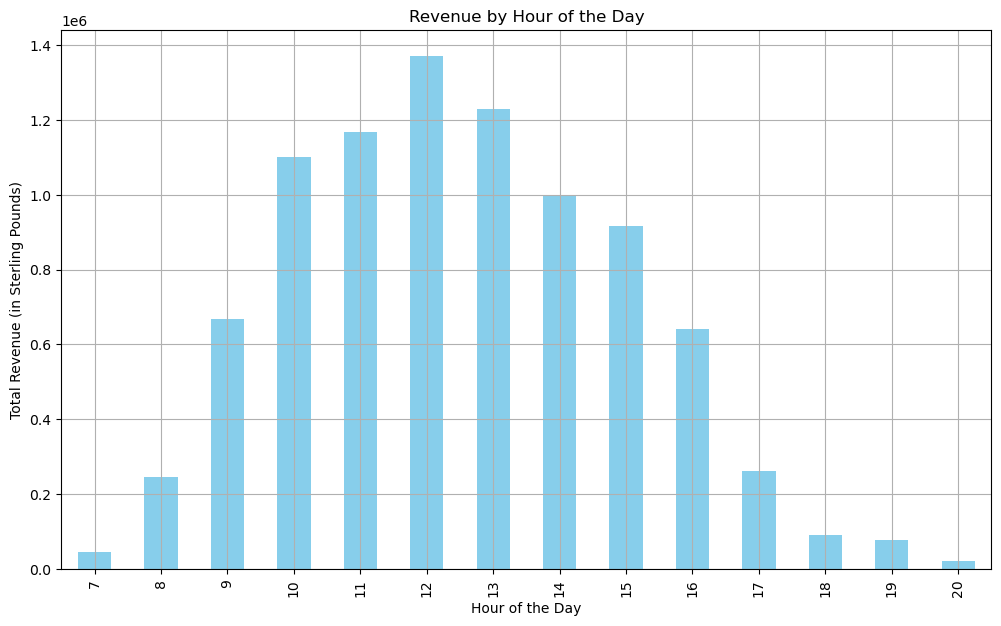

In [31]:
# Extract the hour from the InvoiceDate column and add it to data_copy
data_copy['Hour'] = data_copy['InvoiceDate'].dt.hour

# Extract the hour from the InvoiceDate column and group by the hour to sum the TotalPrice for each hour
hourly_revenue = data_copy.groupby(data_copy['InvoiceDate'].dt.hour)['TotalPrice'].sum()

# Plot the hourly revenue
plt.figure(figsize=(12, 7))
hourly_revenue.plot(kind='bar', color='skyblue')
plt.title('Revenue by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Total Revenue (in Sterling Pounds)')
plt.grid(True)
plt.show()

del hourly_revenue

### Identifying which day of the week accounts for the most revenue generated

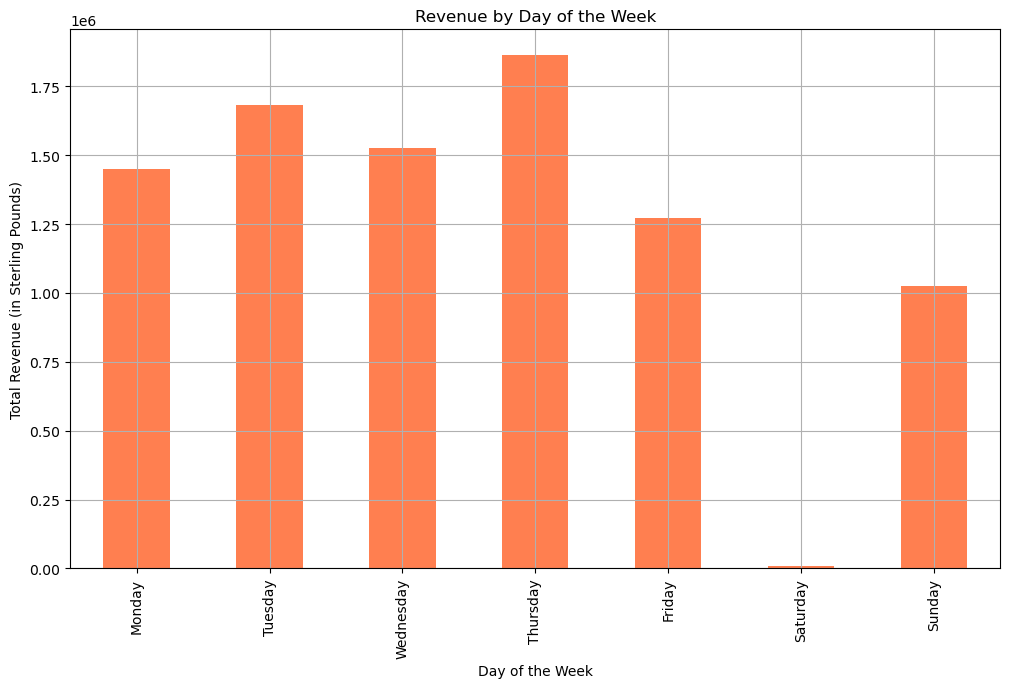

In [29]:
# Extract the day of the week from the InvoiceDate column and add it to data_copy
data_copy['DayOfWeek'] = data_copy['InvoiceDate'].dt.day_name()

day_of_week_revenue = data_copy.copy()
day_of_week_revenue['DayOfWeek'] = day_of_week_revenue['InvoiceDate'].dt.day_name()

# Group by the day of the week and sum the TotalPrice for each day
day_of_week_revenue = day_of_week_revenue.groupby('DayOfWeek')['TotalPrice'].sum()

# Sort the days of the week in the correct order
day_of_week_revenue = day_of_week_revenue.reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# Plot the revenue by day of the week
plt.figure(figsize=(12, 7))
day_of_week_revenue.plot(kind='bar', color='coral')
plt.title('Revenue by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue (in Sterling Pounds)')
plt.grid(True)
plt.show()

del day_of_week_revenue

### Find how many customers are repeat customers

Number of repeat customers: 2893
Number of non-repeat customers: 1419


C:\Users\harry\AppData\Local\Temp\ipykernel_17628\1216517499.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Repeat Customers', 'Non-Repeat Customers'], y=[repeat_customers, non_repeat_customers], palette='pastel')


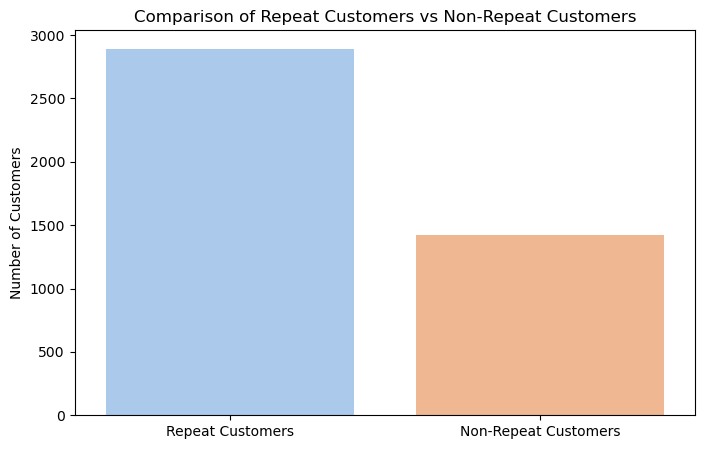

In [28]:
# Group by CustomerID and count the number of unique InvoiceNo for each customer
customer_invoices = data_copy.groupby('CustomerID')['InvoiceNo'].nunique()

# Classify customers as repeat or non-repeat
repeat_customers = customer_invoices[customer_invoices > 1].count()
non_repeat_customers = customer_invoices[customer_invoices == 1].count()

# Print the results
print(f"Number of repeat customers: {repeat_customers}")
print(f"Number of non-repeat customers: {non_repeat_customers}")

# Plot the comparison
plt.figure(figsize=(8, 5))
sns.barplot(x=['Repeat Customers', 'Non-Repeat Customers'], y=[repeat_customers, non_repeat_customers], palette='pastel')
plt.title('Comparison of Repeat Customers vs Non-Repeat Customers')
plt.ylabel('Number of Customers')
plt.show()

del repeat_customers, non_repeat_customers

### Identify top customers, amount of revenue they bring in, and whether or not they are repeat customers

In [18]:
# Group by CustomerID and sum the TotalPrice for each customer
customer_revenue = data_copy.groupby('CustomerID')['TotalPrice'].sum()

# Sort the customers by revenue in descending order
top_customers = customer_revenue.sort_values(ascending=False)

# Determine the top 10 customers by revenue
top_10_customers = top_customers.head(10)

# Check if the top customers are repeat customers
top_10_customers_repeat_status = customer_invoices[top_10_customers.index].apply(lambda x: 'Repeat' if x > 1 else 'Non-Repeat')

# Calculate the percentage of total revenue for each top customer
top_10_customers_percentage = (top_10_customers / total_revenue) * 100

# Combine the revenue, percentage, and repeat status into a single DataFrame
top_10_customers_df = pd.DataFrame({
    'Revenue': top_10_customers,
    'Percentage of Total Revenue': top_10_customers_percentage,
    'Repeat Status': top_10_customers_repeat_status
})

print("Top 10 customers by revenue, their repeat status, and percentage of total revenue:\n")
top_10_customers_df

del top_10_customers, top_10_customers_repeat_status, top_10_customers_percentage, top_customers, top_10_customers_df

Top 10 customers by revenue, their repeat status, and percentage of total revenue:



## 2. Customer Segmentation
#### Recency, Frequency, and Monetary (RFM) clustering analysis

Cluster
4    3650
0     597
2      52
1      10
3       3
Name: count, dtype: int64


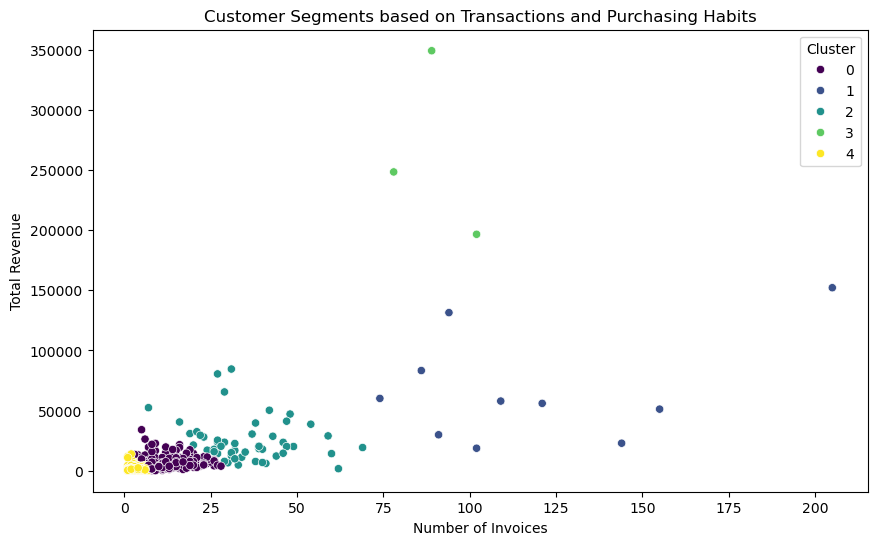

In [33]:
# Create a DataFrame with the features for clustering
customer_features = pd.DataFrame({
    'InvoiceCount': customer_invoices,
    'TotalRevenue': customer_revenue
})

# Standardize the features
scaler = StandardScaler()
customer_features_scaled = scaler.fit_transform(customer_features)

# Apply k-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features_scaled)

# Print the number of customers in each cluster
print(customer_features['Cluster'].value_counts())

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='InvoiceCount', y='TotalRevenue', hue='Cluster', data=customer_features, palette='viridis')
plt.title('Customer Segments based on Transactions and Purchasing Habits')
plt.xlabel('Number of Invoices')
plt.ylabel('Total Revenue')
plt.legend(title='Cluster')
plt.show()